In [15]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import random
import matplotlib.pyplot as plt

### Support functions

In [16]:
# Function that resamples trajectory to have M evenly spaced points
def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g
    
# Function that computes the total length of the trajectory
def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

# Function that computes the Fourier Descriptor Transform
def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

# Function that computes the Inverse Fourier Descriptor Transform
def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

def get_descriptors(filepath, M=100):
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    Z = fourier_descriptor_transform(g)
    return Z

def archimedas_spiral(theta_range, a0, granularity=500):
    theta = np.linspace(theta_range[0], theta_range[1], granularity)
    arch_x = a0*theta*np.cos(theta)
    arch_y = a0*theta*np.sin(theta)
    
    return (arch_x,arch_y)

def archimedas_descriptor(theta_range, a0, granularity=500):
    arch = archimedas_spiral(theta_range, a0, granularity)
    
    arch_traj = resample_trajectory([(x,y) for x,y in zip(arch[0],arch[1])],M)
    Z_archimedes = fourier_descriptor_transform(arch_traj)
    
    return Z_archimedes

def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
        
    plt.show()

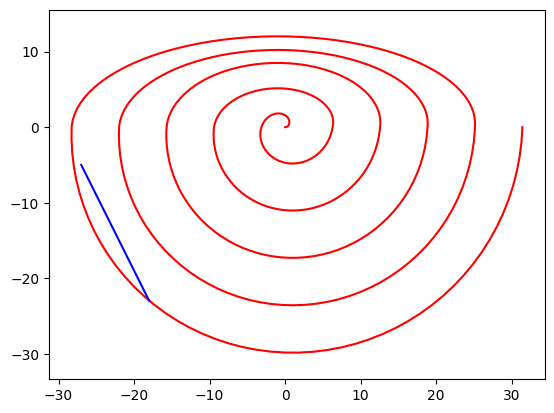

In [17]:
theta_range = [0,10*np.pi]
a0 = [1]*500
b0 = [1]*100 + [0.65]*50 + [1]*50 + [0.6]*50 + [1]*50  + [0.5]*50 + [1]*50 + [0.45]*50 + [1]*50

theta = np.linspace(theta_range[0], theta_range[1], 500)
arch_x = a0*theta*np.cos(theta)
arch_y = b0*theta*np.sin(theta)

start_p = (-18,-23)
end_p = (-27,-5)
line = np.array([start_p, end_p])


plt.plot(arch_x, arch_y, color='red')
plt.plot(line[:,0], line[:,1], color='blue')
plt.axis('equal')
plt.show()

### Loading spirals

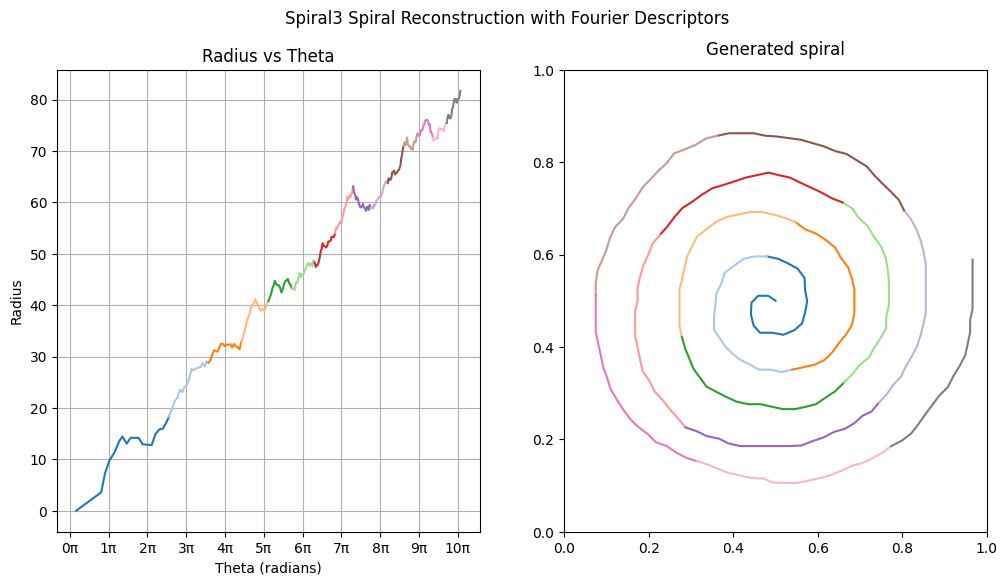

In [22]:
# directory = "drawings/long/"
# filename = "l_flat3"
directory = "drawings/long/"
filename = "l_spiral3"
filepath = directory + filename + ".csv"

descriptors = get_descriptors(filepath, M=300)
g_recon = np.array(list(inverse_fourier_descriptor_transform(descriptors).values()))
sp_x, sp_y = remove_end_line(g_recon[:,0], g_recon[:,1])
sp_y = -sp_y  # Invert y-axis if necessary
sp_r = np.sqrt(sp_x**2 + sp_y**2)
sp_theta = np.arctan2(sp_y, sp_x)
sp_theta = np.unwrap(sp_theta)

parts = [p.capitalize() for p in filename.split("_")]
plot_title = f"{' '.join(parts[1:])} Spiral Reconstruction with Fourier Descriptors"

plot_segmented_spiral(
    gen_theta=sp_theta,
    gen_r=sp_r,
    num_segments=15,
    num_points=len(sp_theta),
    colors=None,
    figsize=(12, 6),
    plot_title=plot_title
)

### Spiral in polar coordinates

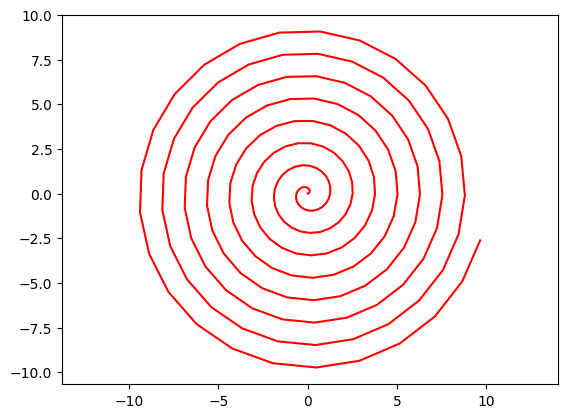

In [5]:
## Polar Coordinates
k = 0
a = 5
n = 1

r = np.linspace(0, 10, 200)
theta = k + a*r**n

arch_x = r * np.cos(theta)
arch_y = r * np.sin(theta)

plt.plot(arch_x, arch_y, color='red')
plt.axis('equal')
plt.show()

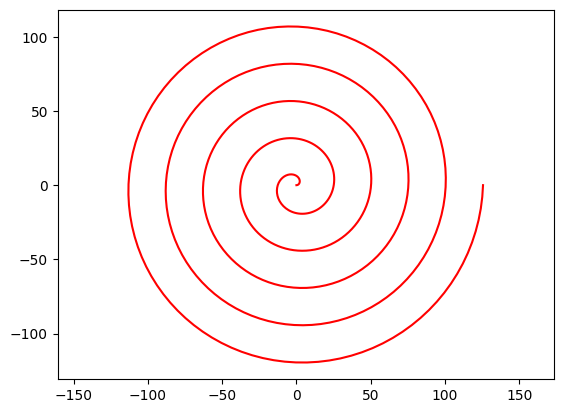

In [6]:
theta_range = [0,10*np.pi]
a0 = [4]*500
b0 = [4]*500

theta = np.linspace(theta_range[0], theta_range[1], 500)
arch_x = a0*theta*np.cos(theta)
arch_y = b0*theta*np.sin(theta)

plt.plot(arch_x, arch_y, color='red')
plt.axis('equal')
plt.show()

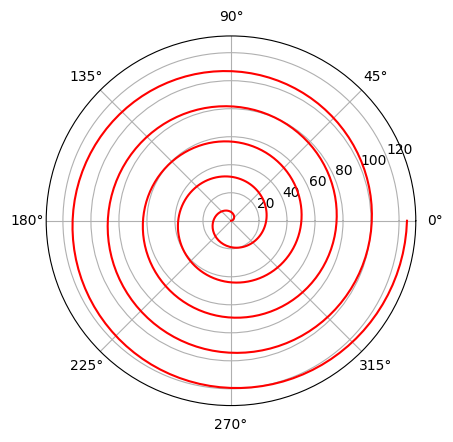

In [7]:
x0, y0 = arch_x[0], arch_y[0]

r = np.sqrt((arch_x - x0)**2 + (arch_y - y0)**2)
theta = np.arctan2(arch_y - y0, arch_x - x0)

plt.polar(theta, r, color='red')
plt.show()

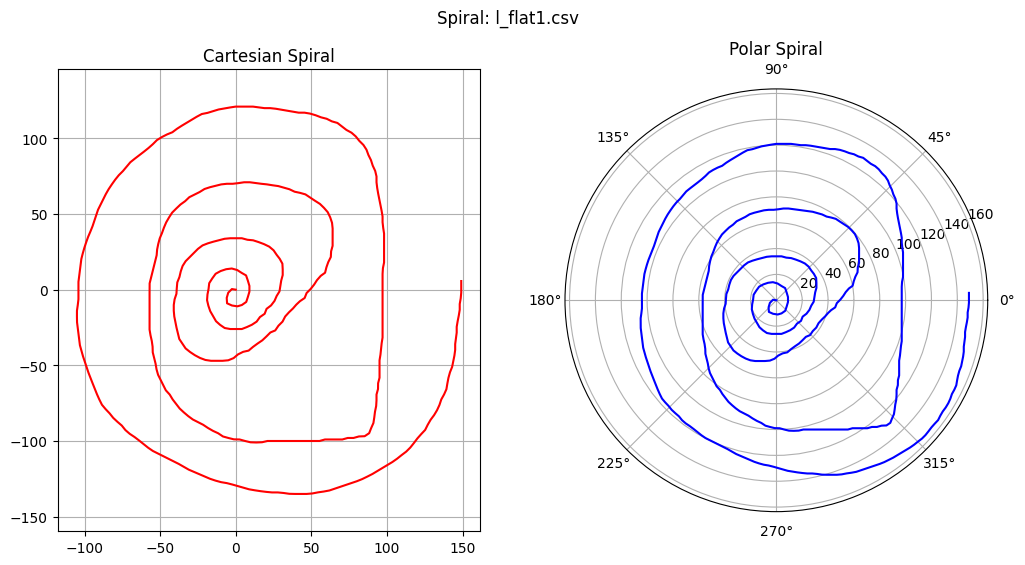

In [8]:
df = pd.read_csv("drawings/long/l_all_dft_reconstructed_500.csv")
grouped = df.groupby("original_file")
sp_name, sp_df = list(grouped)[0]

sp_x = sp_df['x'] - sp_df['x'].iloc[0]
sp_y = sp_df['y'] - sp_df['y'].iloc[0]
sp_x, sp_y = remove_end_line(sp_x, sp_y, tol=1e-6)

sp_r = np.sqrt(sp_x**2 + sp_y**2)
sp_theta = np.arctan2(sp_y, sp_x)

sp_theta = np.unwrap(sp_theta)
fig = plt.figure(figsize=(12, 6))

# Cartesian subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(sp_x, sp_y, color='red')
ax1.set_title("Cartesian Spiral")
ax1.axis('equal')
ax1.grid(True)

# Polar subplot
ax2 = fig.add_subplot(1, 2, 2, projection='polar')
ax2.plot(sp_theta, sp_r, color='blue')
ax2.set_title("Polar Spiral")
ax2.grid(True)

plt.suptitle(f"Spiral: {sp_name}")
plt.show()

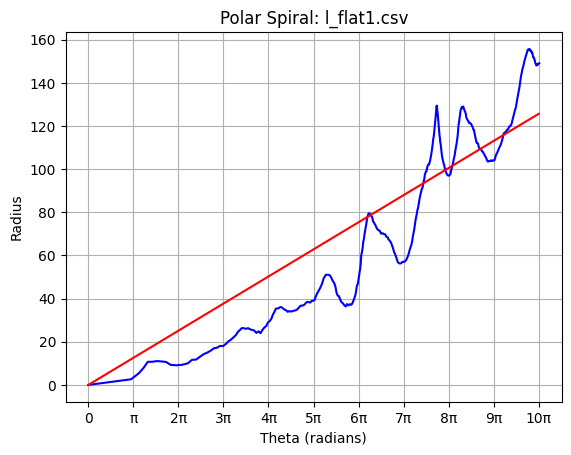

In [9]:
plt.plot(sp_theta, sp_r, color='blue')
theta = np.unwrap(theta)
plt.plot(theta, r, color='red')
plt.title(f"Polar Spiral: {sp_name}")
plt.grid(True)
plt.xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi, 6*np.pi, 7*np.pi, 8*np.pi, 9*np.pi, 10*np.pi],
           ['0', 'π', '2π', '3π', '4π', '5π', '6π', '7π', '8π', '9π', '10π'])
plt.xlabel("Theta (radians)")
plt.ylabel("Radius")
plt.show()

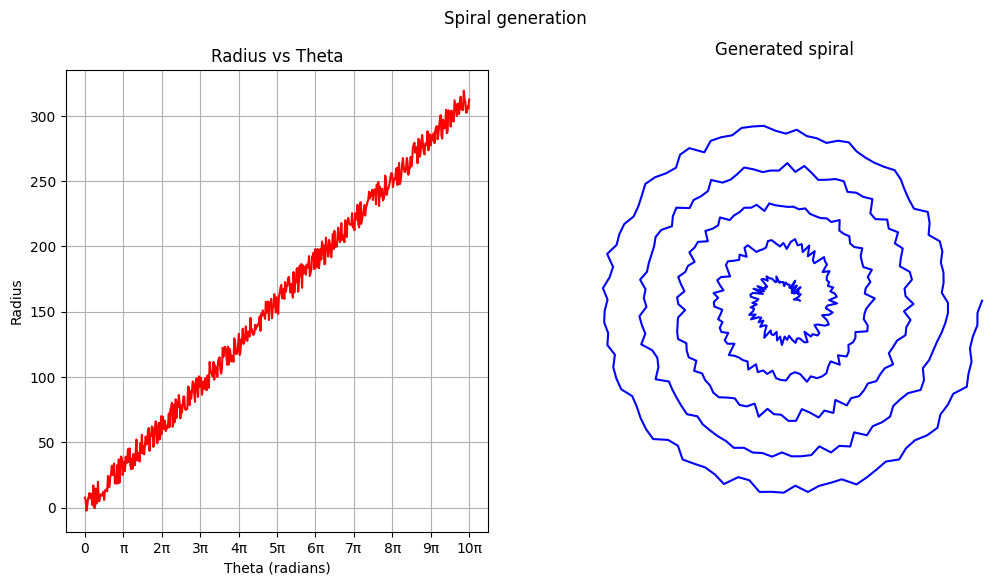

In [10]:
gen_theta = np.linspace(0, 10*np.pi, 500)
gen_r = list(10*gen_theta)

gen_r = [val + random.uniform(-10,10) for val in gen_r]
# gen_r = [val + 50*np.sin(th) for val, th in zip(gen_r[:300], gen_theta[:300])] + gen_r[300:]

fig = plt.figure(figsize=(12, 6))

# Cartesian subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(np.unwrap(gen_theta), gen_r, color='red')
ax1.set_title("Radius vs Theta")
ax1.grid(True)
ax1.set_xticks([0, np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi, 6*np.pi, 7*np.pi, 8*np.pi, 9*np.pi, 10*np.pi],
           ['0', 'π', '2π', '3π', '4π', '5π', '6π', '7π', '8π', '9π', '10π'])
ax1.set_xlabel("Theta (radians)")
ax1.set_ylabel("Radius")

# Polar subplot
ax2 = fig.add_subplot(1, 2, 2, projection='polar')
ax2.plot(gen_theta, gen_r, color='blue')
ax2.set_title("Generated spiral")
ax2.grid(False)
ax2.axis('off')

plt.suptitle(f"Spiral generation")
plt.show()

In [11]:
def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6)
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    plt.show()

# Example usage of the function
# plot_segmented_spiral(sp_theta, sp_r, num_segments=20)

### Tightness

In [12]:
def find_intersections(spiral, line):
    sp_x, sp_y = spiral
    line_start, line_end = line
    intersections = []
    
    q1 = np.array(line_start)
    q2 = np.array(line_end)
    r = q2 - q1  # direction of line

    for i in range(len(sp_x) - 1):
        p1 = np.array([sp_x[i], sp_y[i]])
        p2 = np.array([sp_x[i + 1], sp_y[i + 1]])
        s = p2 - p1  # direction of segment

        denom = r[0] * s[1] - r[1] * s[0]
        if abs(denom) < 1e-12:
            continue  # parallel

        t = ((p1[0] - q1[0]) * s[1] - (p1[1] - q1[1]) * s[0]) / denom
        u = ((p1[0] - q1[0]) * r[1] - (p1[1] - q1[1]) * r[0]) / denom

        # intersection happens only if both within [0,1]
        if 0 <= t <= 1 and 0 <= u <= 1:
            intersection_point = q1 + t * r
            intersections.append(intersection_point)

    return np.array(intersections)

def distribution_dist(intersections, line, max_r, centre=(0,0), pretty_print=False):
    if len(intersections) < 3:
        return None
    
    line_start, line_end = line
    q1 = np.array(line_start)
    q2 = np.array(line_end)
    r = q2 - q1  # direction of line
    
    side_1, side_2 = [centre], [centre]
    
    for point in intersections:
        if point.tolist() == centre:
            continue
        vec = point - centre
        dot = r[0] * vec[0] + r[1] * vec[1]
        if dot > 0:
            side_1.append(point)
        elif dot < 0:
            side_2.append(point)
            
    dists_1, dists_2 = [], []
    
    for i in range(len(side_1)-1):
        p1, p2 = side_1[i], side_1[i+1]
        dist = np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
        dists_1.append(dist)
        
    for i in range(len(side_2)-1):
        p1, p2 = side_2[i], side_2[i+1]
        dist = np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
        dists_2.append(dist)
    
    dists_1 = np.array(dists_1)
    dists_2 = np.array(dists_2)
    
    if len(dists_1) == 0 or len(dists_2) == 0:
        return None
    if np.abs(len(dists_1)-len(dists_2)) > 1:
        return None

    mean1, mean2 = np.mean(dists_1), np.mean(dists_2)
    std1, std2 = np.std(dists_1), np.std(dists_2)
    
    if pretty_print:
        print(f"Distances side 1: {dists_1}")
        print(f"Distances side 2: {dists_2}")
        print(f"Side 1: mean={mean1}, std={std1}")
        print(f"Side 2: mean={mean2}, std={std2}")
    # Bhattacharyya distance
    Bhatt_dist = (1/4)*(mean1 - mean2)**2/(std1**2 + std2**2) + (1/2)*np.log((std1**2 + std2**2)/(2*std1*std2))
    
    # Hellinger distance
    Hell_dist = np.sum([(np.sqrt(p_i) - np.sqrt(q_i))**2 for p_i, q_i in zip(dists_1,dists_2) ])
    
    return 100* Hell_dist / max_r

def get_line(point, angle, max_r):
    return np.array([(point[0] - max_r*np.cos(angle), point[1] - max_r*np.sin(angle)),
                    (point[0] + max_r*np.cos(angle), point[1] + max_r*np.sin(angle))])

Distances side 1: [11.89203862 36.16584921 52.42539053 53.21574336 66.12211143]
Distances side 2: [ 8.38966983  9.15309688  8.19595419 12.04844676 14.41459863 19.38866429]
Side 1: mean=43.96422663001412, std=18.641854250888557
Side 2: mean=11.931738431836381, std=4.000148778352755
Max distribution distance: 27.232160753734103


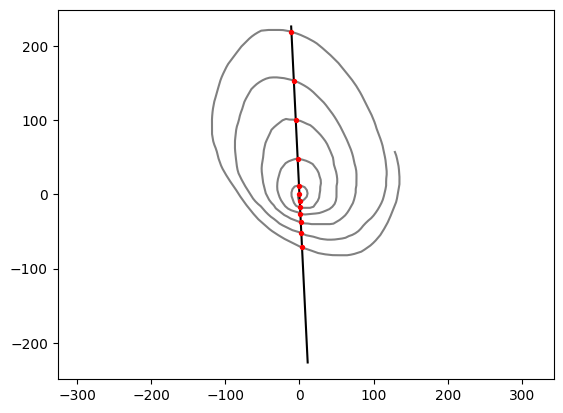

In [13]:
sp_name, sp_df = list(grouped)[16]

sp_x = sp_df['x'] - sp_df['x'].iloc[0]
sp_y = sp_df['y'] - sp_df['y'].iloc[0]
sp_r = np.sqrt(sp_x**2 + sp_y**2)

sp_x, sp_y = remove_end_line(sp_x, sp_y)
# sp_x, sp_y = arch_x, arch_y
max_r = np.max(sp_r)
point = (0,0)

angles = np.linspace(0, np.pi, 64, endpoint=False)
max_dist = 0
ang_opt = 0

for ang in angles:
    temp_line = get_line(point, ang, max_r)
    temp_dist = distribution_dist(find_intersections((sp_x, sp_y), temp_line), temp_line, max_r)
    if temp_dist is not None and temp_dist > max_dist:
        max_dist = temp_dist
        ang_opt = ang
# max_r = 30
line = get_line(point, ang_opt, max_r)    
intr = find_intersections((sp_x, sp_y), line)
max_dist = distribution_dist(intr, line, max_r, pretty_print=True)
print(f"Max distribution distance: {max_dist}")

plt.plot(sp_x, sp_y, color='grey')
plt.plot(line[:,0], line[:,1], color='black')
plt.scatter(intr[:,0], intr[:,1], color="red", s=8, zorder=5)
plt.axis('equal')
plt.show()

### Flat sections

In [ ]:
def line_sym(spiral_x, spiral_y, line):
    
    line_start, line_end = np.array(line[0]), np.array(line[1])
    line_centre = 0.5 * (line_start + line_end)
    line_len = int(np.sqrt(np.sum((line_end - line_start)**2)))
    pts = [line_start + t * (line_end - line_start) for t in np.linspace(0, 1, 20)]
    
    dists_to_centre = np.sqrt((spiral_x - line_centre[0])**2 + (spiral_y - line_centre[1])**2)
    sp_c_idx = np.argmin(dists_to_centre)
    
    sym = 0.0
    n = len(spiral_x)
    window = line_len // 2
    
    for pt in pts:
        idx_min = max(sp_c_idx - window, 0)
        idx_max = min(sp_c_idx + window, n)
        xw, yw = spiral_x[idx_min:idx_max], spiral_y[idx_min:idx_max]
        dists = np.sqrt((xw - pt[0])**2 + (yw - pt[1])**2)
        sym += np.min(dists)
    
    return sym / len(pts)

def generate_line_space(spiral_x, spiral_y, max_r):
    max_len = 2 * max_r
    c_points = zip(spiral_x,spiral_y)
    angles = np.linspace(0, np.pi, 180, endpoint=False)
    lengths = np.linspace(max_len//3, max_len//2, 5)

    line_space = []
    for c in c_points:
        for ang in angles:
            for l in lengths:
                line_space.append((c, get_line(c, ang, l/2)))
            
    return line_space


def get_lines(spiral_x, spiral_y, line_space, min_dist=1.5, seed=41, num_samples=10000):
    best_lines = []

    random.seed(seed)
    random_lines = random.sample(line_space, num_samples)

    for _, line in random_lines:
        sym = line_sym(spiral_x, spiral_y, line)
        if sym < min_dist:
            best_lines.append(line)
            
    return best_lines

In [ ]:
sp_name, sp_df = list(grouped)[1]

sp_x = sp_df['x'] - sp_df['x'].iloc[0]
sp_y = sp_df['y'] - sp_df['y'].iloc[0]
sp_x, sp_y = remove_end_line(sp_x, sp_y)
sp_r = np.sqrt(sp_x**2 + sp_y**2)
max_r = np.max(sp_r)

line_space = generate_line_space(sp_x, sp_y, max_r) 

No lines found with the given minimum distance.


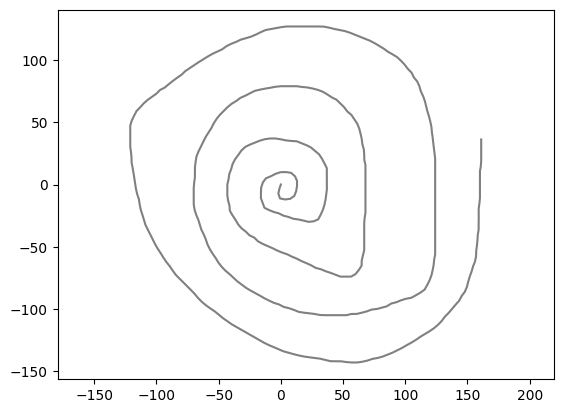

In [ ]:
best_lines = get_lines(sp_x, sp_y, line_space, min_dist=1.5, seed=42, num_samples=20000)
distances = [line_sym(sp_x, sp_y, line) for line in best_lines]

if len(distances) == 0:
    print("No lines found with the given minimum distance.")
else:
    print(f"Distances min: {np.min(distances)}, max: {np.max(distances)}, mean: {np.mean(distances)}")

plt.plot(sp_x, sp_y, color='grey')
for line in best_lines:
    plt.plot(line[:,0], line[:,1], color='red', alpha=0.7)

plt.axis('equal')
plt.show()

In [ ]:
#test_line = np.array([(-79, -37), (-22,60)])
#print(line_sym(sp_x, sp_y, test_line))
#plt.plot(test_line[:,0], test_line[:,1], color='blue', alpha=0.7)